In [6]:
import tensorflow as tf
import os
from tensorflow.keras import datasets
import matplotlib.pyplot as plt
import numpy as np
from numpy import loadtxt
import pandas as pd
from keras.models import Sequential
from keras.layers import MaxPool2D, Conv2D, Flatten, Dense, Activation, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.initializers import RandomNormal, Constant
from tensorflow.keras import optimizers
import pickle
from tensorflow import keras
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

In [7]:
_CIFAR_IMAGE_SIZE = 32
def load_data(path, labels_number=1):
  with tf.io.gfile.GFile(path, 'rb') as f:
    data = f.read()
  offset = 0
  max_offset = len(data) - 1
  coarse_labels = []
  fine_labels = []
  images = []
  while offset < max_offset:
    labels = np.frombuffer(
        data, dtype=np.uint8, count=labels_number, offset=offset
    ).reshape((labels_number,))
    offset += labels_number
    img = (
        np.frombuffer(data, dtype=np.uint8, count=3072, offset=offset)
        .reshape((3, _CIFAR_IMAGE_SIZE, _CIFAR_IMAGE_SIZE))
        .transpose((1, 2, 0))
    )
    offset += 3072
    coarse_labels.append(labels[0])
    fine_labels.append(labels[1])
    images.append(img)
  return [np.array(coarse_labels), np.array(fine_labels), np.array(images)]


In [8]:
def load_labels(path):
    return loadtxt(path, comments="#", delimiter=",", unpack=False, dtype='str')

def load_cifar100():
    url = "https://www.cs.toronto.edu/~kriz/cifar-100-binary.tar.gz"
    dataset = tf.keras.utils.get_file("cifar.tar.gz", url,untar=True, cache_dir='.', cache_subdir='')
    dataset_dir = os.path.join(os.path.dirname(dataset), 'cifar-100-binary')
    CY_train, FY_train, X_train = load_data(os.path.join(dataset_dir, 'train.bin'), labels_number=2)
    CY_test, FY_test, X_test = load_data(os.path.join(dataset_dir, 'test.bin'), labels_number=2)
    C_label = load_labels(os.path.join(dataset_dir, 'coarse_label_names.txt'))
    F_label = load_labels(os.path.join(dataset_dir, 'fine_label_names.txt'))
    
    return X_train, CY_train, FY_train, X_test, CY_test, FY_test, C_label, F_label

In [9]:
X_train, CY_train, FY_train, X_test, CY_test, FY_test, C_label, F_label = load_cifar100() #можно было загрузить файл пиклом но так как мы работаем со стандартным cifar100, решил легче подгрузить .

In [10]:
print(X_train.shape,CY_train.shape, FY_train.shape)

(50000, 32, 32, 3) (50000,) (50000,)


In [ ]:
Итак у нас 50000 training images

In [ ]:
Элементы сети, которые зависят от количества цветов, это входной слой и возможно первый сверточный слой.
Входной слой должен иметь три канала для каждого из трех цветов: красного, зеленого и синего.
Первый сверточный слой может иметь фильтры, которые зависят от цвета.
Элементы сети, которые зависят от количества классов, это выходной слой и функция потерь. 
Выходной слой должен иметь количество нейронов, равное количеству классов.
Если количество классов изменится, то количество нейронов в выходном слое должно быть соответственно изменено.

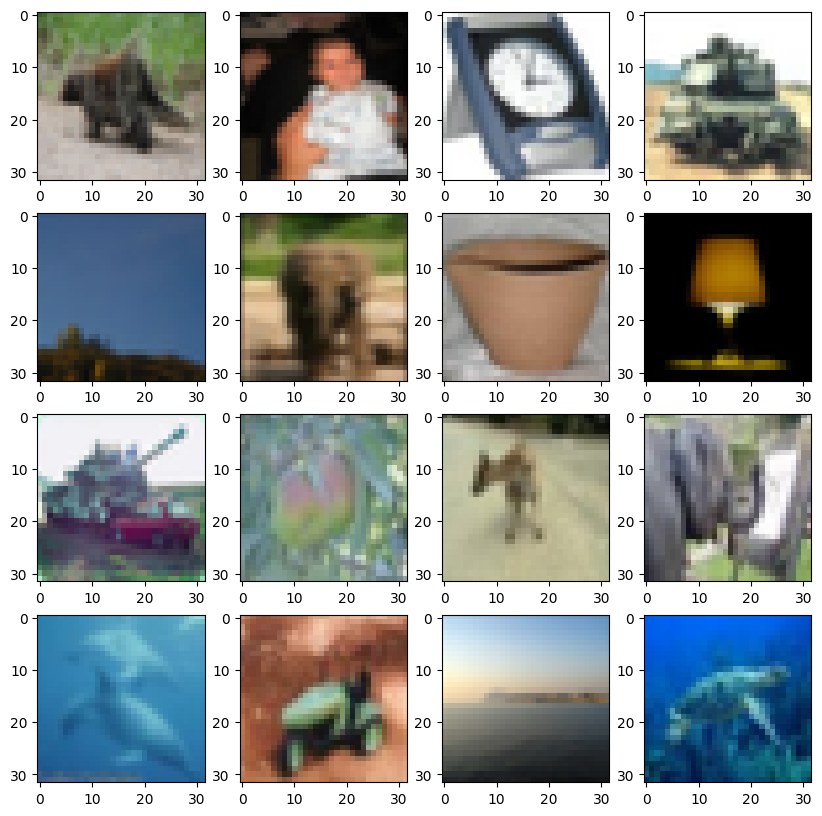

In [11]:
plt.figure(figsize=(10, 10))
for i in range (16):
  rand_num = np.random.randint(0, 50000)
  cifar_img = plt.subplot(4,4, i+1)
  plt.imshow(X_train[rand_num])

In [12]:
def preview_images(classnames, label, images):
    plt.figure(figsize=(12,12))
    for i in range(120):
        plt.subplot(10,12,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i])
        plt.xlabel(classnames[label[i]], labelpad=2, fontsize=6)
    plt.show()

In [6]:
#sub_category = ['beaver', 'dolphin', 'otter', 'seal', 'whale', 
#'aquarium' ,'fish', 'ray', 'shark', 'trout', 
#'orchids', 'poppies', 'roses', 'sunflowers', 'tulips', 
#'bottles', 'bowls', 'cans', 'cups', 'plates', 
#'apples', 'mushrooms', 'oranges', 'pears', 'sweet peppers', 
#'clock', 'computer keyboard', 'lamp', 'telephone', 'television', 'bed', 'chair', 'couch', 'table', 'wardrobe', 
#'bee', 'beetle', 'butterfly', 'caterpillar', 'cockroach', 
#'bear', 'leopard', 'lion', 'tiger', 'wolf', 
#'bridge', 'castle', 'house', 'road', 'skyscraper', 
#'cloud', 'forest', 'mountain', 'plain', 'sea', 
#'camel', 'cattle', 'chimpanzee', 'elephant', 'kangaroo', 
#'fox', 'porcupine', 'possum', 'raccoon', 'skunk', 
#'crab', 'lobster', 'snail', 'spider', 'worm', 
#'baby', 'boy', 'girl', 'man', 'woman', 
#'crocodile', 'dinosaur', 'lizard', 'snake', 'turtle', 
#'hamster', 'mouse', 'rabbit', 'shrew', 'squirrel', 
#'maple', 'oak', 'palm', 'pine', 'willow', 
#'bicycle', 'bus', 'motorcycle', 'pickup truck', 'train', 
#'lawn-mower', 'rocket', 'streetcar', 'tank', 'tractor']
#super_category = ['aquatic mammals', 'fish', 'flowers', 'food containers',
#                  'fruit and vegetables',
#                  'household electrical devices',
#                  'household furniture',
#                  'insects','large carnivores',
#                  'large man-made outdoor things',
#                  'large natural outdoor scenes',
#                  'large omnivores and herbivores','medium-sized mammals',
#                  'non-insect invertebrates','people',
#                  'reptiles','small mammals','trees',
#                  'vehicles 1','vehicles 2']

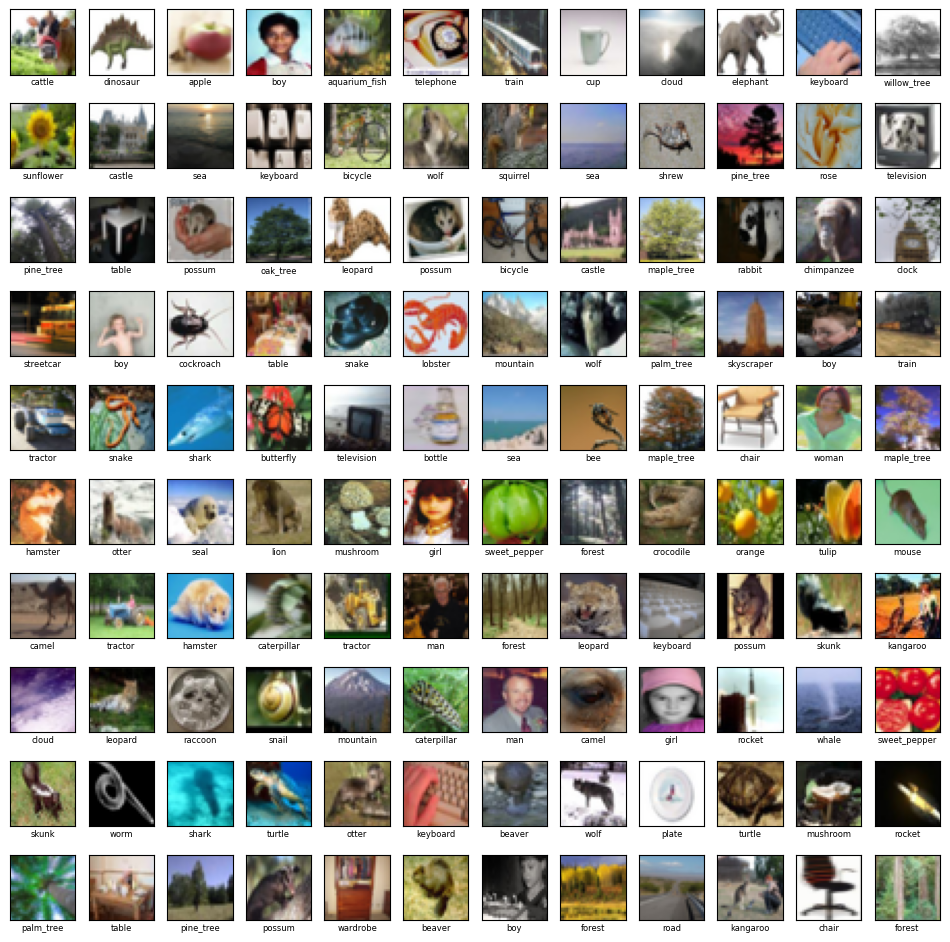

In [13]:
preview_images(F_label, FY_train, X_train)

In [7]:
Построение модели:

In [17]:
from tensorflow.keras import layers, models

def getModel():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(100, activation='softmax'))
    return model


In [ ]:
1. Conv2D:

- Слой Conv2D используется как первый слой модели, так как он принимает на вход изображения размером (32, 32, 3). Он применяет свертку к входным данным с помощью фильтров размером (2, 2) и 32 фильтров.

- Параметр padding='same' означает, что входные данные будут дополнены нулями по краям, чтобы сохранить размерность на выходе.

- Слой имеет шаг свертки (strides) равный (2, 2), что позволяет уменьшить размерность изображения в два раза по ширине и высоте.

- Размещение этого слоя перед слоем пулинга позволяет извлекать первые признаки из изображений и уменьшать размерность данных.

2. MaxPooling2D:

- Слой MaxPooling2D применяется после первого слоя свертки для дальнейшего уменьшения размера пространства признаков.

- Он использует пулинг размером (2, 2), чтобы выбрать максимальные значения из каждой области размером 2x2.

- Параметр padding='same' гарантирует, что размерность данных будет сохранена после пулинга.

- Размещение этого слоя после первого слоя свертки позволяет уменьшить размерность данных и сохранить важные признаки.

3. Conv2D и MaxPooling2D (повторение):

- Это второй блок слоев свертки и пулинга, который выполняет аналогичные операции, но на основе фильтров размером (2, 2) и с 64 фильтрами.

- Размещение этого блока повторяется, чтобы углубить модель, извлекать более сложные признаки и дальше снижать размерность данных.

4. Flatten:

- После последнего слоя пулинга, данные имеют размерность (8, 8, 64). Слой Flatten используется для преобразования пространственных признаков в вектор фиксированной длины.

- Это необходимо для передачи данных в полносвязные слои.

5. Dense (полносвязные слои):

- В представленной модели добавлено два полносвязных слоя с 256 и 128 нейронами соответственно.

- Слой Dense(256) помогает извлекать более абстрактные признаки из преобразованных данных после слоя Flatten.

- Второй слой Dense(128) помогает уменьшить размерность и сжать информацию перед последним слоем с 100 нейронами, который выполняет классификацию по 100 классам в датасете CIFAR-100.

6. Activation и Softmax:

- После каждого полносвязного слоя применяется функция активации ReLU для введения нелинейности и активации скрытых признаков.

- Выходной слой использует функцию активации Softmax, которая преобразует выходы нейронов в вероятности принадлежности к каждому из 100 классов в датасете CIFAR-100.

In [18]:
model = getModel()

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 2, 2, 128)         0

In [20]:
def getCompiledModel():
    model = getModel()
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=['accuracy'])
    return model

In [21]:
model = getCompiledModel()


In [23]:
his = model.fit(X_train, CY_train, epochs=10)

Epoch 1/10
1563/1563 [==============================] - 23s 14ms/step - loss: 2.2931 - accuracy: 0.2970
Epoch 2/10
1563/1563 [==============================] - 22s 14ms/step - loss: 2.0901 - accuracy: 0.3571
Epoch 3/10
1563/1563 [==============================] - 22s 14ms/step - loss: 1.9639 - accuracy: 0.3927
Epoch 4/10
1563/1563 [==============================] - 22s 14ms/step - loss: 1.8578 - accuracy: 0.4239
Epoch 5/10
1563/1563 [==============================] - 22s 14ms/step - loss: 1.7739 - accuracy: 0.4473
Epoch 6/10
1563/1563 [==============================] - 22s 14ms/step - loss: 1.6941 - accuracy: 0.4714
Epoch 7/10
1563/1563 [==============================] - 22s 14ms/step - loss: 1.6295 - accuracy: 0.4898
Epoch 8/10
1563/1563 [==============================] - 22s 14ms/step - loss: 1.5609 - accuracy: 0.5112
Epoch 9/10
1563/1563 [==============================] - 23s 15ms/step - loss: 1.5102 - accuracy: 0.5245
Epoch 10/10
1563/1563 [==============================] - 23s 15m

In [24]:
model.save('./coarse_model.keras')

In [25]:
С_test_loss, С_test_acc = model.evaluate(X_test, CY_test)

print('\nТочность на тестовых данных:', С_test_acc)

313/313 [==============================] - 2s 5ms/step - loss: 1.9267 - accuracy: 0.4387

Точность на тестовых данных: 0.43869999051094055


In [27]:
#Получаем набор вероятностей определения каждой категории
С_predictions = model.predict(X_test)

# Находим максимальные вероятности в наборе предсказаний
С_predictions = np.argmax(С_predictions, axis=-1)

# Отображаем оценку модели
from sklearn.metrics import classification_report

print(classification_report(CY_test, С_predictions, target_names=C_label))

313/313 [==============================] - 2s 5ms/step
                                precision    recall  f1-score   support

               aquatic_mammals       0.27      0.51      0.35       500
                          fish       0.52      0.35      0.42       500
                       flowers       0.66      0.65      0.66       500
               food_containers       0.40      0.47      0.43       500
          fruit_and_vegetables       0.56      0.45      0.50       500
  household_electrical_devices       0.30      0.43      0.36       500
           household_furniture       0.38      0.53      0.45       500
                       insects       0.47      0.44      0.46       500
              large_carnivores       0.36      0.37      0.37       500
 large_man-made_outdoor_things       0.49      0.53      0.51       500
  large_natural_outdoor_scenes       0.57      0.68      0.62       500
large_omnivores_and_herbivores       0.36      0.35      0.35       500
        

In [28]:
tf.keras.backend.clear_session()

model = model = getCompiledModel()

his = model.fit(X_train, FY_train, epochs=10) # Обучение на узких классах

Epoch 1/10


C:\Users\Nikita\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\backend.py:5729: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1563/1563 [==============================] - 23s 14ms/step - loss: 4.0346 - accuracy: 0.0945
Epoch 2/10
1563/1563 [==============================] - 22s 14ms/step - loss: 3.4038 - accuracy: 0.1847
Epoch 3/10
1563/1563 [==============================] - 22s 14ms/step - loss: 3.1475 - accuracy: 0.2334
Epoch 4/10
1563/1563 [==============================] - 22s 14ms/step - loss: 2.9686 - accuracy: 0.2660
Epoch 5/10
1563/1563 [==============================] - 22s 14ms/step - loss: 2.8289 - accuracy: 0.2912
Epoch 6/10
1563/1563 [==============================] - 22s 14ms/step - loss: 2.7162 - accuracy: 0.3161
Epoch 7/10
1563/1563 [==============================] - 22s 14ms/step - loss: 2.6185 - accuracy: 0.3342
Epoch 8/10
1563/1563 [==============================] - 22s 14ms/step - loss: 2.5324 - accuracy: 0.3514
Epoch 9/10
1563/1563 [==============================] - 22s 14ms/step - loss: 2.4573 - accuracy: 0.3663
Epoch 10/10
1563/1563 [==============================] - 24s 16ms/step - lo

In [29]:
model.save('./fine_model.keras')

In [30]:
F_test_loss, F_test_acc = model.evaluate(X_test, FY_test)

313/313 [==============================] - 2s 5ms/step - loss: 3.0252 - accuracy: 0.2891


In [31]:
F_predictions = model.predict(X_test)

# Находим максимальные вероятности в наборе предсказаний
F_predictions = np.argmax(F_predictions, axis=-1)

# Отображаем оценку модели
print(classification_report(FY_test, F_predictions, target_names=F_label))
F_report = classification_report(FY_test, F_predictions, target_names=F_label, output_dict = True)

313/313 [==============================] - 2s 5ms/step
               precision    recall  f1-score   support

        apple       0.45      0.65      0.53       100
aquarium_fish       0.34      0.38      0.36       100
         baby       0.24      0.25      0.24       100
         bear       0.26      0.11      0.15       100
       beaver       0.14      0.11      0.12       100
          bed       0.26      0.22      0.24       100
          bee       0.28      0.30      0.29       100
       beetle       0.28      0.23      0.25       100
      bicycle       0.20      0.28      0.23       100
       bottle       0.52      0.39      0.45       100
         bowl       0.24      0.09      0.13       100
          boy       0.14      0.21      0.17       100
       bridge       0.32      0.37      0.34       100
          bus       0.20      0.13      0.16       100
    butterfly       0.16      0.36      0.22       100
        camel       0.17      0.16      0.16       100
         

In [33]:
def init_fine_map():
    map = {
        "aquatic_mammals": ["beaver", "dolphin", "otter", "seal", "whale"],
        "fish": ["aquarium_fish", "flatfish", "ray", "shark", "trout"],
        "flowers": ["orchid", "poppy", "rose", "sunflower", "tulip"],
        "food_containers": ["bottle", "bowl", "can", "cup", "plate"],
        "fruit_and_vegetables": ["apple", "mushroom", "orange", "pear", "sweet_pepper"],
        "household_electrical_devices": ["clock", "keyboard", "lamp", "telephone", "television"],
        "household_furniture": ["bed", "chair", "couch", "table", "wardrobe"],
        "insects": ["bee", "beetle", "butterfly", "caterpillar", "cockroach"],
        "large_carnivores": ["bear", "leopard", "lion", "tiger", "wolf"],
        "large_man-made_outdoor_things": ["bridge", "castle", "house", "road", "skyscraper"],
        "large_natural_outdoor_scenes": ["cloud", "forest", "mountain", "plain", "sea"],
        "large_omnivores_and_herbivores": ["camel", "cattle", "chimpanzee", "elephant", "kangaroo"],
        "medium_mammals": ["fox", "porcupine", "possum", "raccoon", "skunk"],
        "non-insect_invertebrates": ["crab", "lobster", "snail", "spider", "worm"],
        "people": ["baby", "boy", "girl", "man", "woman"],
        "reptiles": ["crocodile", "dinosaur", "lizard", "snake", "turtle"],
        "small_mammals": ["hamster", "mouse", "rabbit", "shrew", "squirrel"],
        "trees": ["maple_tree", "oak_tree", "palm_tree", "pine_tree", "willow_tree"],
        "vehicles_1": ["bicycle", "bus", "motorcycle", "pickup_truck", "train"],
        "vehicles_2": ["lawn_mower", "rocket", "streetcar", "tank", "tractor"],
    }
    dict = {}
    for label in F_label:
        for key in map:
            if label in map[key]:
                dict.update({label: key})
                break
    return dict

fine_to_coarse = init_fine_map()

In [34]:
FC = lambda i: fine_to_coarse[F_label[i]]
CF_predictions = np.array([FC(i) for i in F_predictions])
C_index = lambda i: np.where(C_label == i)[0][0]
CF_predictions = np.array([C_index(i) for i in CF_predictions])

In [ ]:
Оценка prediction узких до меток широкого класса

In [35]:
print(classification_report(CY_test, CF_predictions, target_names=C_label))
CF_report = classification_report(CY_test, CF_predictions, target_names=C_label, output_dict = True)

                                precision    recall  f1-score   support

               aquatic_mammals       0.38      0.30      0.34       500
                          fish       0.41      0.39      0.40       500
                       flowers       0.63      0.60      0.61       500
               food_containers       0.50      0.33      0.40       500
          fruit_and_vegetables       0.56      0.48      0.51       500
  household_electrical_devices       0.31      0.37      0.34       500
           household_furniture       0.51      0.47      0.49       500
                       insects       0.38      0.56      0.45       500
              large_carnivores       0.29      0.46      0.35       500
 large_man-made_outdoor_things       0.61      0.46      0.52       500
  large_natural_outdoor_scenes       0.73      0.53      0.61       500
large_omnivores_and_herbivores       0.36      0.27      0.31       500
                medium_mammals       0.32      0.36      0.34  

In [37]:
print(classification_report(CY_test, С_predictions, target_names=C_label))
C_report = classification_report(CY_test, С_predictions, target_names=C_label, output_dict = True)

                                precision    recall  f1-score   support

               aquatic_mammals       0.27      0.51      0.35       500
                          fish       0.52      0.35      0.42       500
                       flowers       0.66      0.65      0.66       500
               food_containers       0.40      0.47      0.43       500
          fruit_and_vegetables       0.56      0.45      0.50       500
  household_electrical_devices       0.30      0.43      0.36       500
           household_furniture       0.38      0.53      0.45       500
                       insects       0.47      0.44      0.46       500
              large_carnivores       0.36      0.37      0.37       500
 large_man-made_outdoor_things       0.49      0.53      0.51       500
  large_natural_outdoor_scenes       0.57      0.68      0.62       500
large_omnivores_and_herbivores       0.36      0.35      0.35       500
                medium_mammals       0.41      0.25      0.31  

In [38]:
# Точность распознавания узкого класса
F_precision =  lambda i: F_report[i]['precision']
F_precisions = np.array([F_precision(i) for i in F_label])

#Точность распознавания широкого класса по узкому
CF_precision =  lambda i: CF_report[fine_to_coarse[i]]['precision']
CF_precisions = np.array([CF_precision(i) for i in F_label])

# Точность распознавания соответствующего широкого класса
C_precision =  lambda i: C_report[fine_to_coarse[i]]['precision']
C_precisions = np.array([C_precision(i) for i in F_label])

<Axes: >

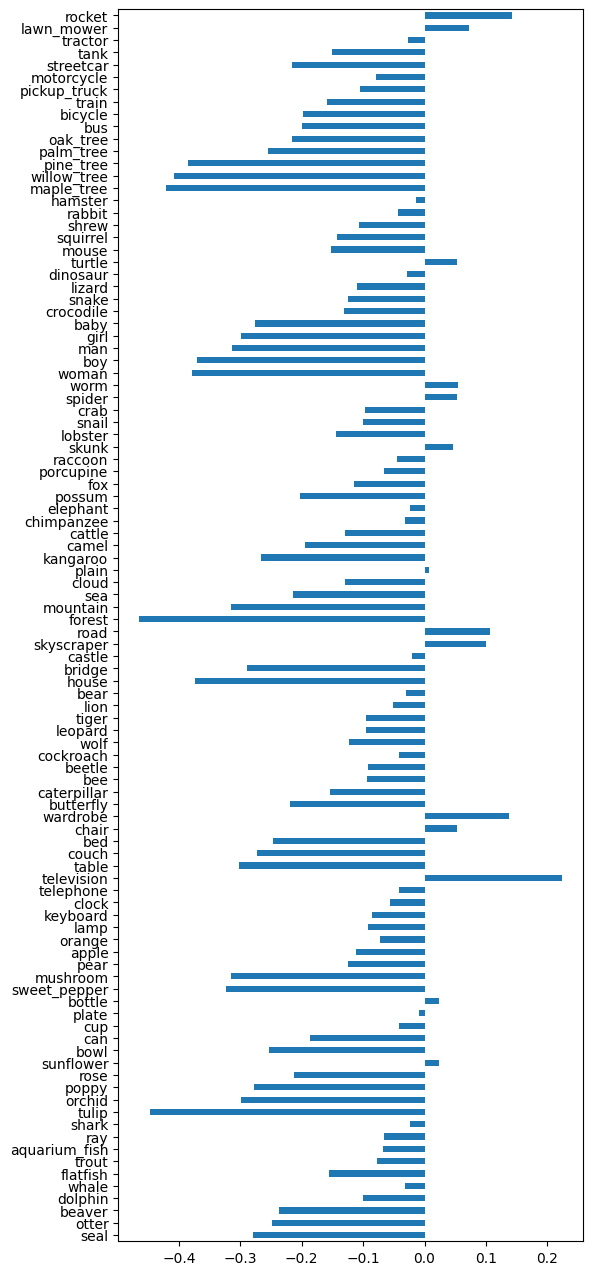

In [39]:
df = pd.DataFrame(
    {
     'label': F_label,
     'c_label': np.array([fine_to_coarse[i] for i in F_label]),
     'F_CF': F_precisions - CF_precisions,
     'F_C': F_precisions - C_precisions,
     'CF_C': CF_precisions - C_precisions,
    })

# График различия точности распознавания узкого класса и точности распознавания широкого класса по узкому
df.sort_values(by=['c_label', 'F_CF'],ascending=True).plot.barh(y='F_CF', x='label', legend=False, figsize=(6, 16), ylabel='')

<Axes: >

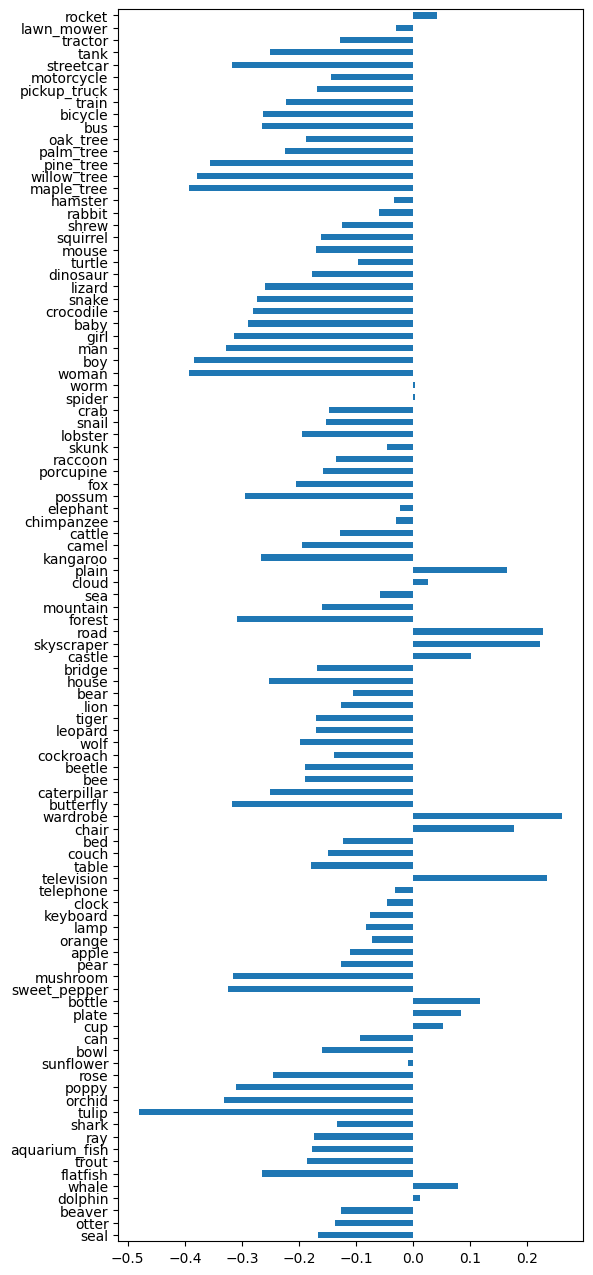

In [40]:
# График различия точности распознавания узкого класса и точности распознавания широкого класса
df.sort_values(by=['c_label', 'F_C'],ascending=True).plot.barh(y='F_C', x='label', legend=False, figsize=(6, 16), ylabel='')

In [ ]:
График различия точности распознавания широкого класса по узкому и точности распознавания широкого класса позволяет сделать вывод о том, какие категории
лучше определяются при обучении на узких классах, а какие на широких.